# Path-integral Monte Carlo for the 1d oscillator
Jan Gukelberger, Andreas Hehn, Georg Winkler, Dominik Gresch (2011-2017)

In [1]:
from __future__ import division, print_function

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from sys import stdout
%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 9

In [2]:
# hbar = m = 1
w = 1.0
# seed random number generator once at program start
rnd.seed(42)

### Class for storing world-line configuration and doing updates/measurements

A note on kinetic energy: it was shown that calculating the kinetic energy of a configuration as $\langle KE\rangle=\frac{1}{2M}\sum_{i=0}^{M-1}\left(\frac{x_{j+1}-x_j}{\Delta\tau}\right)^2$ is unstable when the number of timeslices is large due to the growth of the variance of the estimator. A numerically preferred form is $\langle KE\rangle=\frac{1}{2}\langle x\frac{dV}{dx}\rangle$, obtained from the Virial theorem.

Reference: https://aip.scitation.org/doi/10.1063/1.442815

In [9]:
def V_oscillator(x):
    return w ** 2 * x ** 2 / 2.

def V_Higgs(x, eta):
    return (x ** 2 - eta ** 2) ** 2

def dVdx_oscillator(x):
    return w ** 2 * x

def dVdx_Higgs(x, eta):
    return 4 * x  * (x ** 2 - eta ** 2)


class Config:
    """PIMC configuration: world-line for one particle"""

    def __init__(self, beta, numslices, V, dVdx):
        self._beta = beta
        self._numslices = numslices
        self._tau = self._beta / self._numslices    # \Delta\tau=\beta/M
        self._config = rnd.uniform(-1., 1., numslices)    # initial configuration
        print("Initial configuration: ", self._config)
        print("length of configuration: ", self._config.size)
        self.V = V
        self.dVdx = dVdx

    def potential_energy(self):
        """Return the potential energy of a configuration X"""
        # implement here
        energy = 0.0
        for i in self._config:
            energy += self.V(i)
        return energy/self._numslices

    def kinetic_energy(self):
        """Return the kinetic energy of a configuration X"""
        # implement here
        energy = 0.0
        for i in self._config:
            energy += 0.5*i*self.V(i)
        return energy/self._numslices
        
    def position_histogram(self, bins, value_range):
        """Return histogram of positions in all time slices"""
        return np.histogram(self._config, bins, range=value_range)[0]

    def update(self, max_displacement):
        """Metropolis algorithm local configuration update"""
        j = rnd.randint(0,self._config.size) # pick a random time slice 
        new_position_j = rnd.uniform(-max_displacement,max_displacement) + self._config[j]# propose a new position where \Delta x\in[-max_displacement, max_displacement]

        # periodic boundary conditions 
        jp1 = (j + 1) % self._config.size

        acceptance_ratio = np.exp(
            - ((self._config[j - 1] - new_position_j)**2 + (new_position_j - self._config[jp1])**2
               - ((self._config[j - 1] - self._config[j]) ** 2 + (self._config[j] - self._config[jp1])**2)
               ) / (2.0 * self._tau)
            - self._tau * (self.V(new_position_j) - self.V(self._config[j]))
        )
        
        if acceptance_ratio >= 1 or rnd.uniform() < acceptance_ratio:
            self._config[j] = new_position_j
            return True
        else:
            return False

    def sweep(self, max_displacement):
        """One sweep of Metropolis local updates (i.e. self._slices update proposals)"""
        accepted_proposals = 0
        for l in range(self._config.size):
            accepted_proposals += self.update(max_displacement)
        return accepted_proposals / self._numslices    # to calculate acceptance rate later

### Autocorrelation analysis

This is again binning analysis, the same as the past 2 exercises.

In [5]:
def stats(samples, n_levels=9):
    """
    Perform a binning analysis over samples and return an array of the error estimates at each binning level.
    
    """
    bins = np.array(samples)
    errors = np.zeros(n_levels + 1)
    errors[0] = np.std(bins) / np.sqrt(len(bins) - 1)
    for k in range(n_levels):
        bins = np.array([(bins[2*i]+bins[2*i+1])/2. for i in range(len(bins)//2)])
        errors[k+1] = np.std(bins) / np.sqrt(len(bins) - 1)
    # calculate autocorrelation time
    tau = 0.5*(errors[-1]**2/np.std(samples)**2*(len(samples)-1.)-1.)
    
    return np.mean(samples), errors[-1], tau

### PIMC simulation and measuring energies

Here you implement the core part of the simulation and the autocorrelation analysis.

In [15]:
# simulation parameters
beta = 1.
P = 10
max_displacement = .5
# parameters for wave function measurements (x histogram)
histo_range = (-4.0, 4.0)
histo_bins = 100
histo_samples = 64

def simulate(config, steps, thermal_steps):
    # initialize configuration and observables
    potential_energy = np.empty(steps, dtype=float)
    kinetic_energy = np.empty(steps, dtype=float)
    position_histogram = np.zeros((histo_samples, histo_bins))
    acc_rate = 0.

    # thermalize configuration
    print('Thermalization (' + str(thermal_steps) + ' sweeps)...')
    for i in range(thermal_steps):
        config.sweep(max_displacement)

    # simulation: measures after each update sweep
    print('Simulation (' + str(steps) + ' sweeps)')
    for i in range(steps):
        acc_rate += config.sweep(max_displacement)

        # Measurements
        potential_energy[i] = config.potential_energy()
        kinetic_energy[i] = config.kinetic_energy()
        position_histogram[i * histo_samples //
                           steps] += config.position_histogram(histo_bins, histo_range)

        # Progress marker: one . for each percent
        if i % (steps // 100) == 0:
            stdout.write('.')
            stdout.flush()

    # If the acceptance rate is not somewhere around 0.5, max_displacement
    # needs to be tuned.
    acc_rate /= steps
    print('\nAcceptance rate = ' + str(acc_rate))
    
    return potential_energy, kinetic_energy, position_histogram


def autocorrelation_analysis(potential_energy, kinetic_energy, steps):
    # Evaluate results
    pot, pot_error, pot_autocorr = stats(potential_energy)
    kin, kin_error, kin_autocorr = stats(kinetic_energy)
    etot, etot_error, etot_autocorr = stats(potential_energy + kinetic_energy)

    # running mean
    pot_series = np.cumsum(potential_energy) / np.arange(1, steps + 1)
    kin_series = np.cumsum(kinetic_energy) / np.arange(1, steps + 1)

    print("Potential Energy = " + str(pot) + " +/- " +
          str(pot_error) + "\tCorrelation time: " + str(pot_autocorr))
    print("Kinetic Energy   = " + str(kin) + " +/- " +
          str(kin_error) + "\tCorrelation time: " + str(kin_autocorr))
    print("Total Energy     = " + str(etot) + " +/- " + 
          str(etot_error) + "\tCorrelation time: " + str(etot_autocorr))
    
    return pot, kin, pot_series, kin_series


#### Plotting the energy

Take care to normalise the histogram!

In [22]:
def plot_energy(potential_energy, kinetic_energy, pot, kin, pot_series, kin_series, position_histogram, steps, ylim=[0.1, 0.7]):
    # Plot raw samples
    plt.figure()
    plt.title('Potential Energy Samples')
    plt.xlabel('MC step')
    plt.ylabel('potential energy')
    plt.plot(potential_energy, label='$V_i$')
    plt.plot([0, steps - 1], [pot, pot], label='$\\bar{V}$')
    plt.xlim([0, 10000])
    plt.legend()

    # Plot raw samples
    plt.figure()
    plt.title('Kinetic Energy Samples')
    plt.xlabel('MC step')
    plt.ylabel('kinetic energy')
    plt.plot(range(steps),kinetic_energy,label='$T_i$')
    plt.plot([0,steps-1],[kin,kin],label='$\\bar{T}$')
    plt.xlim([0, 10000])
    plt.legend()

    # Plot running mean
    plt.figure()
    plt.title('Time series for energy observables')
    plt.xlabel('MC steps')
    plt.ylabel('energy')
    plt.plot(range(steps), pot_series, label='$\\bar{V}_i$')
    plt.plot([0, steps - 1], [pot, pot], label='$\\bar{V}$')
    plt.plot(range(steps), kin_series, label='$\\bar{T}_i$')
    plt.plot([0, steps - 1], [kin, kin], label='$\\bar{T}$')
    plt.ylim(ylim)
    plt.legend()

    # Normalize histogram and calculate error bars:
    # We did not collect a complete time series, but a fixed number of bins.
    # This works as long as the size of each bin [steps/histo_samples] >>
    # [autocorrelation time]
    position_histogram /= np.sum(position_histogram,
                                 axis=1).reshape((histo_samples, 1))
    histomean = np.mean(position_histogram, axis=0)
    histoerr = np.std(position_histogram, axis=0) / np.sqrt(histo_samples - 1)

    # Plot wave function
    plt.figure()
    plt.title('Wave function')
    plt.xlabel('x')
    plt.ylabel("$|\\psi|^2$")
    binwidth = (histo_range[1] - histo_range[0]) / histo_bins
    plt.errorbar(np.linspace(histo_range[
                 0] + binwidth / 2, histo_range[1] - binwidth / 2, histo_bins), histomean, histoerr)
    plt.show()
    
    return None


## 1. Harmonic oscillator

#### PIMC simulation

In [23]:
step = 100000
thermal_step = 20000  
c = Config(beta, P, V_oscillator, dVdx_oscillator)
pe, ke, xs = simulate(c, step, thermal_step)

Initial configuration:  [ 0.97231609  0.06555444  0.94728828  0.42555592  0.49222522  0.31806975
  0.6279212  -0.0849698  -0.93226476  0.46598551]
length of configuration:  10
Thermalization (20000 sweeps)...
Simulation (100000 sweeps)
....................................................................................................
Acceptance rate = 0.5943719999998428


In [24]:
pe_mean, ke_mean, pe_running, ke_running = autocorrelation_analysis(pe, ke, step)
print('Exact result   E = ' + str(.5 * w / np.tanh(.5 * w * beta)))

Potential Energy = 0.5000369650045086 +/- 0.03804979919951012	Correlation time: 156.58287597845734
Kinetic Energy   = -0.031231025000496366 +/- 0.05873661472443231	Correlation time: 176.44821102940796
Total Energy     = 0.4688059400040123 +/- 0.0658441783937564	Correlation time: 177.72172276971241
Exact result   E = 1.0819767068693265


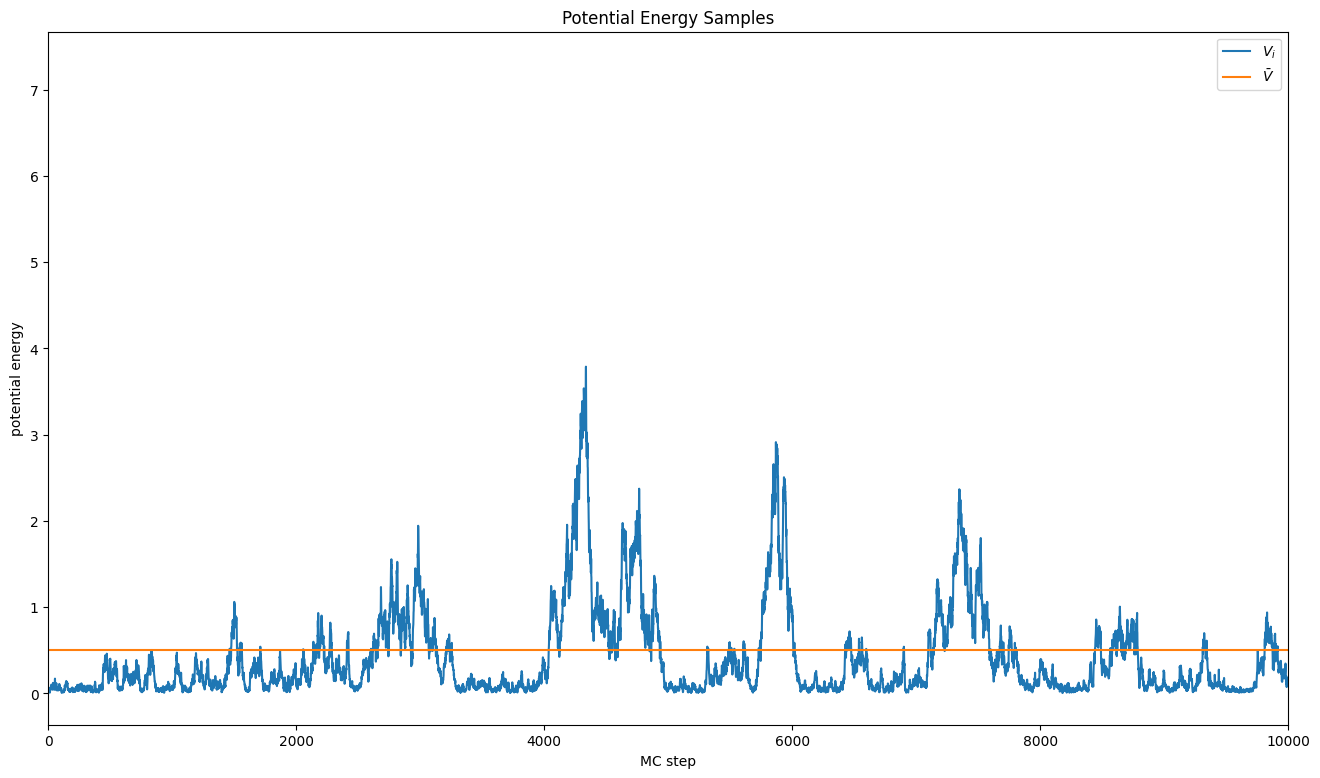

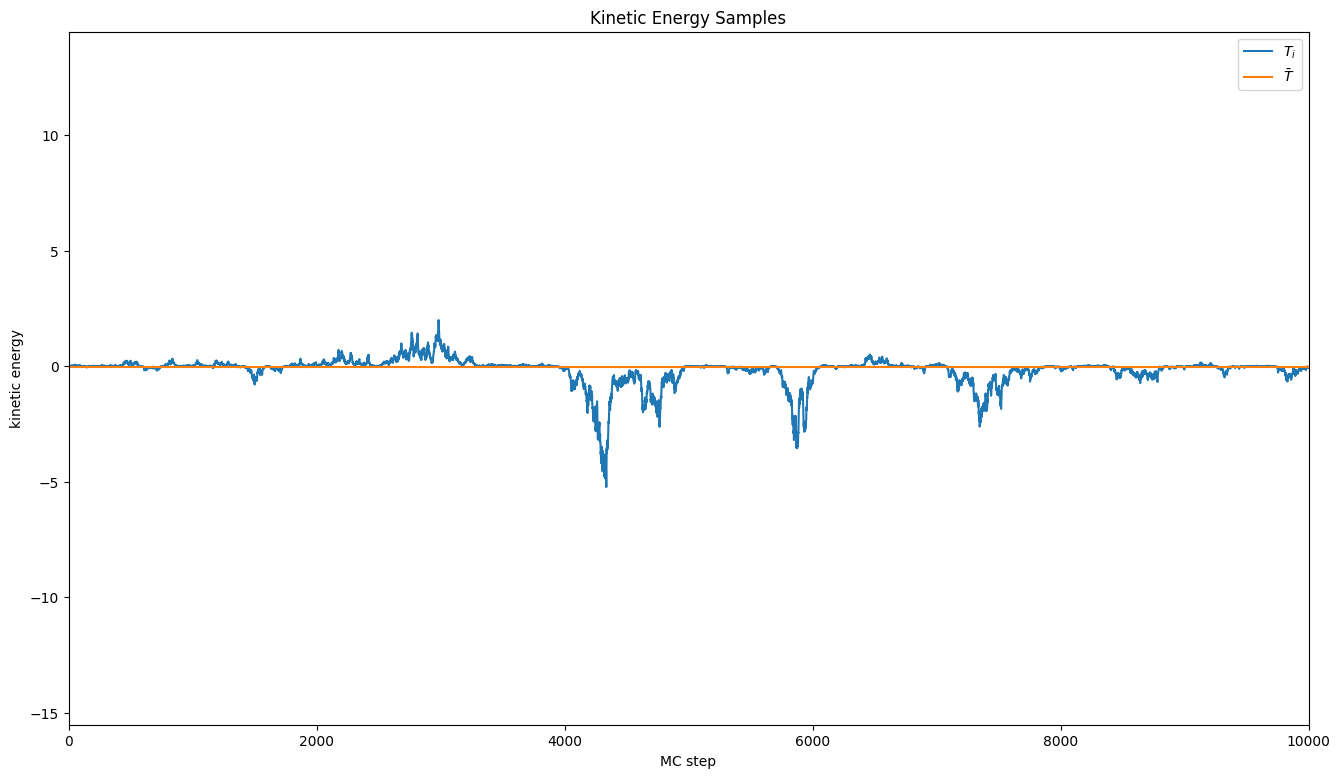

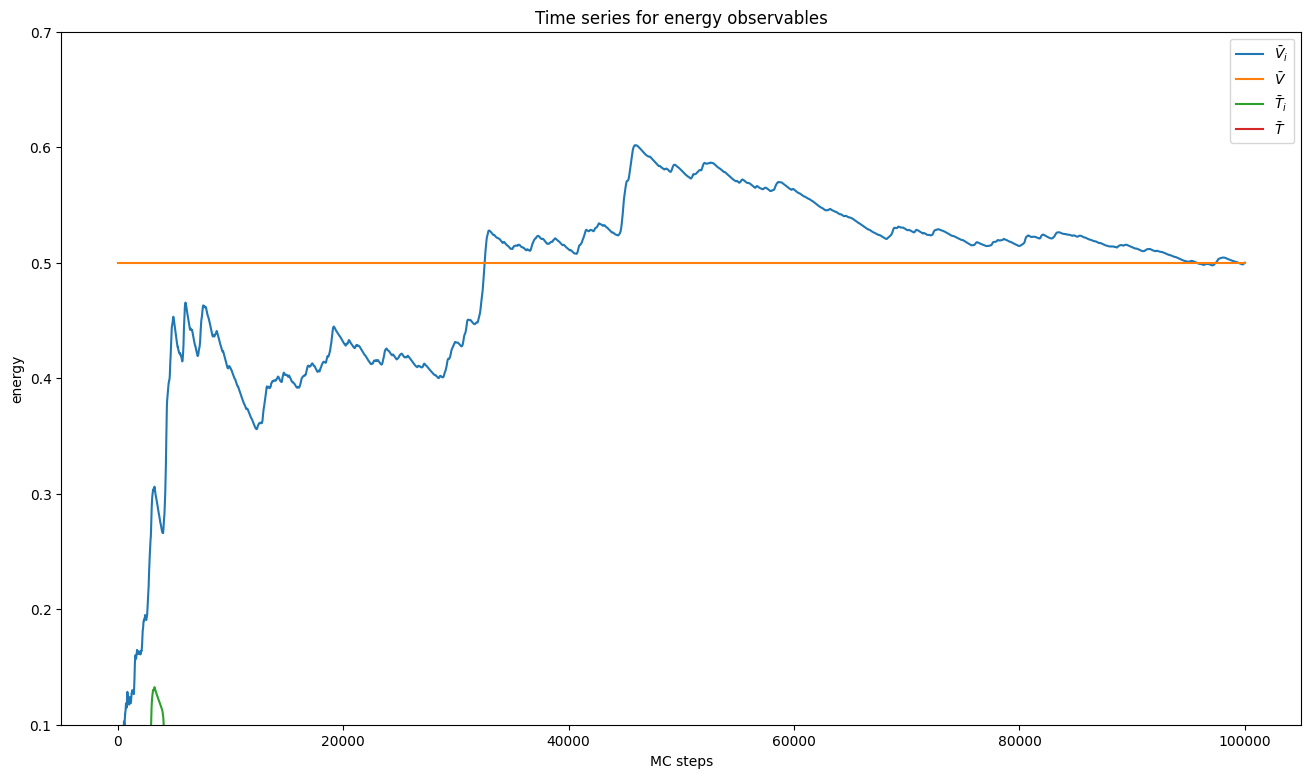

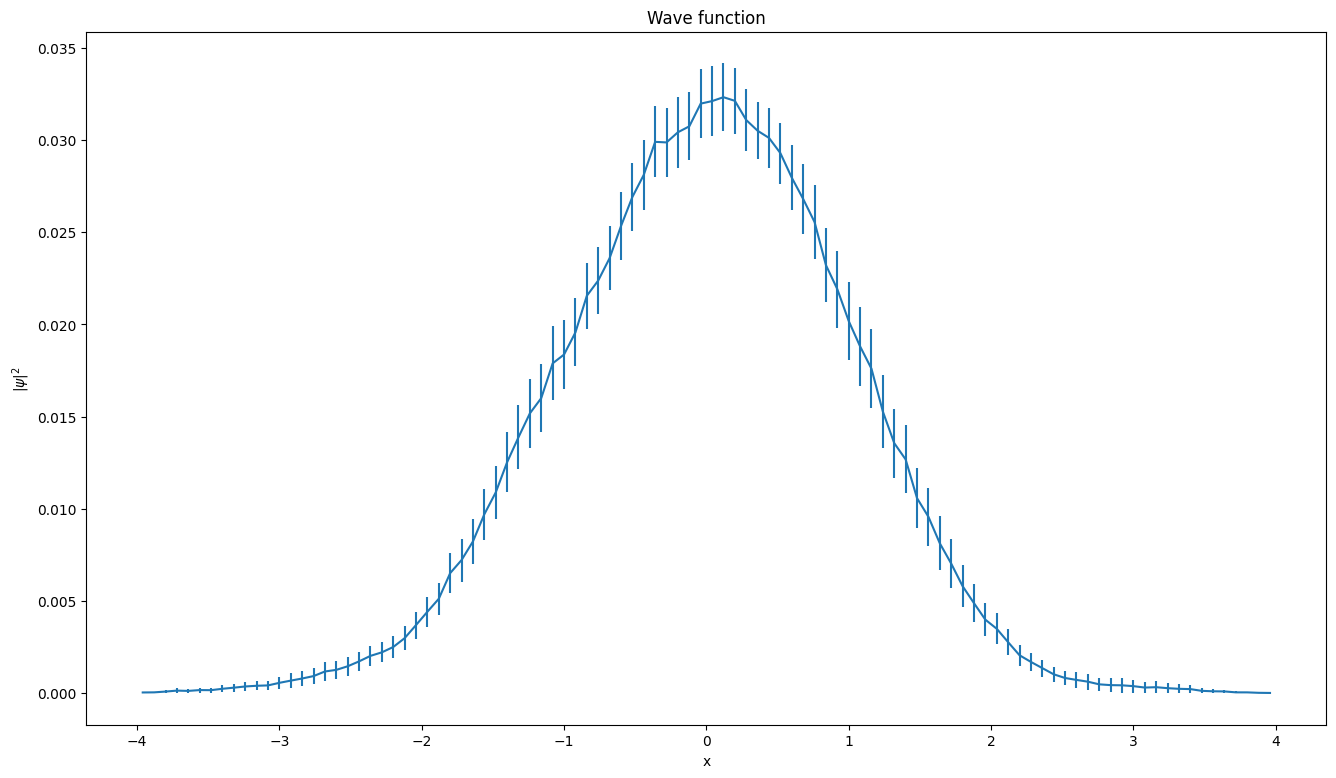

In [25]:
plot_energy(pe, ke, pe_mean, ke_mean, pe_running, ke_running, xs, step)

## 2. Higgs potential

Let us first plot the potential at various values of $\eta$. There are two minima at $\pm\eta$.

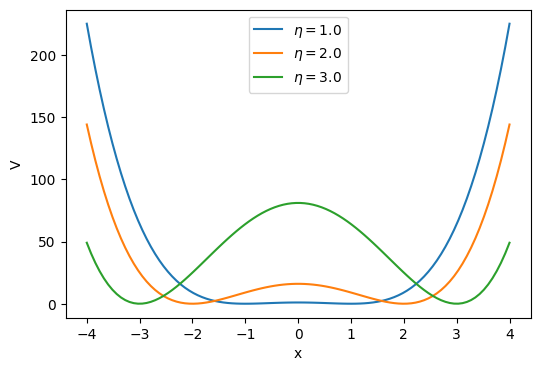

In [26]:
x = np.linspace(-4., 4., 100)
eta_vals = [1., 2., 3.]
plt.figure(figsize=(6,4))
for eta in eta_vals:
    plt.plot(x, V_Higgs(x, eta), label='$\eta=$'+str(eta))
plt.xlabel('x')
plt.ylabel('V')
plt.legend()
plt.show()

#### PIMC simulation

Initial configuration:  [ 0.49490122  0.11967303 -0.74244001  0.44463761  0.66529022 -0.80570511
 -0.97184141 -0.00128093 -0.210854    0.42311558]
length of configuration:  10
Thermalization (20000 sweeps)...
Simulation (100000 sweeps)
....................................................................................................
Acceptance rate = 0.5914439999998471
Potential Energy = 0.5915011322108669 +/- 0.00965706461714347	Correlation time: 21.006549997787236
Kinetic Energy   = -0.02271737446371476 +/- 0.020781114392109962	Correlation time: 81.61954106247077
Total Energy     = 0.5687837577471522 +/- 0.022549858133667642	Correlation time: 55.41153102580684


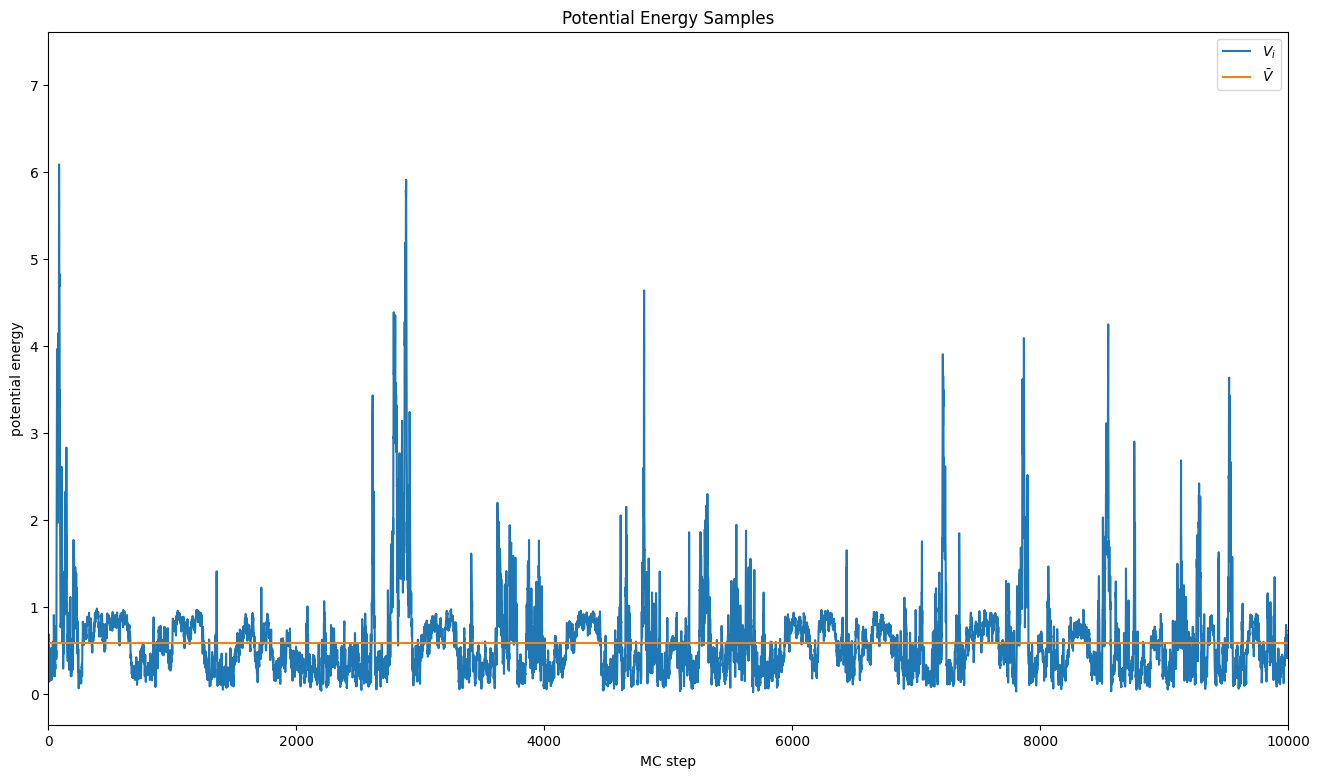

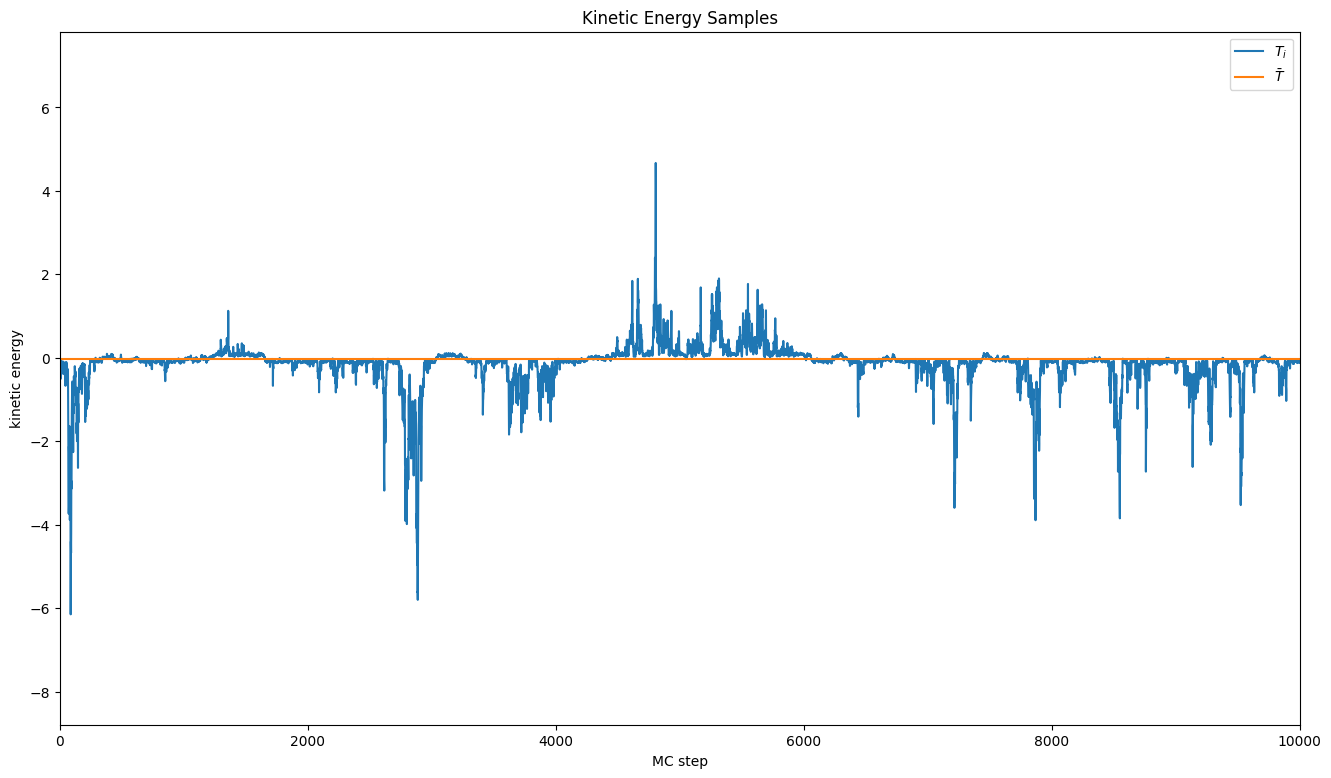

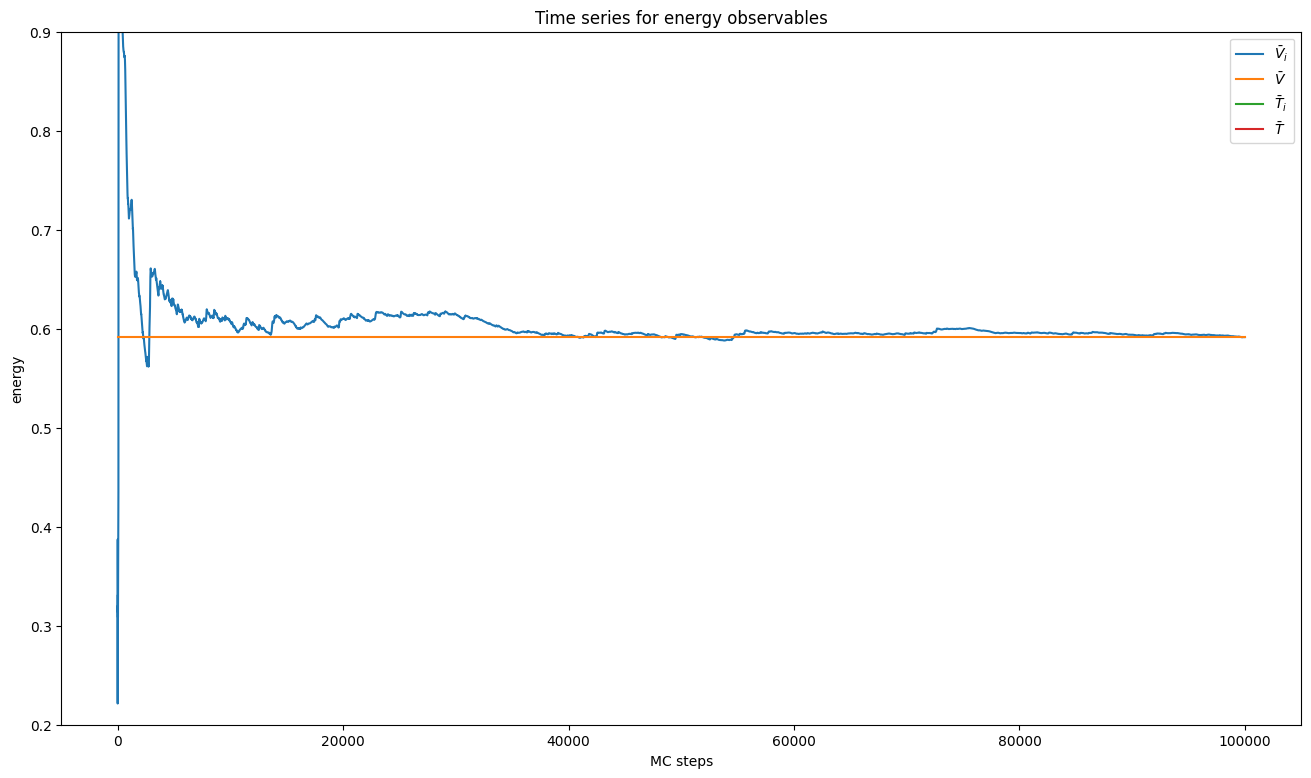

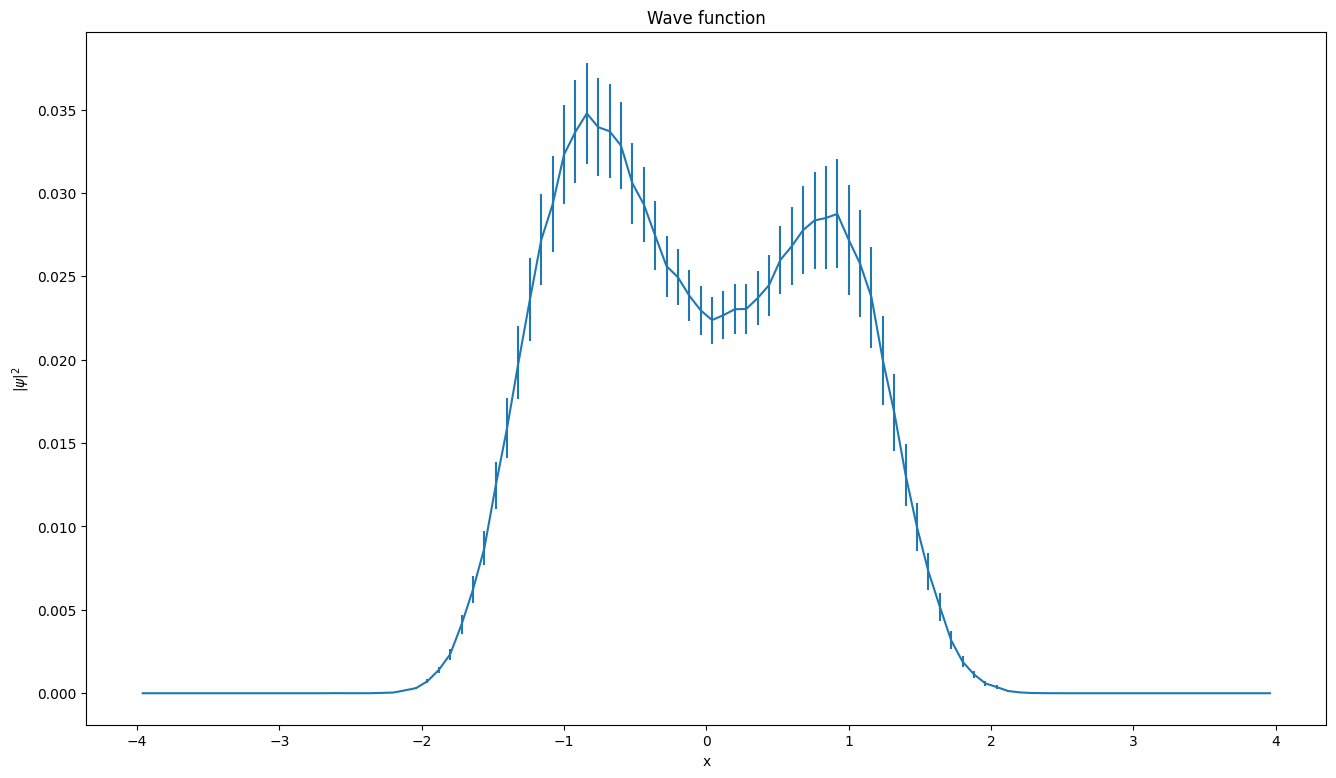

Initial configuration:  [ 0.68320335 -0.10176808 -0.83939758  0.2688544   0.14392595  0.18784798
 -0.48925975  0.15936089 -0.18379375  0.47015233]
length of configuration:  10
Thermalization (20000 sweeps)...
Simulation (100000 sweeps)
....................................................................................................
Acceptance rate = 0.544509999999909
Potential Energy = 1.9591482757998415 +/- 0.01092782875952202	Correlation time: 4.7890675140037775
Kinetic Energy   = 2.8861550012689334 +/- 0.01667140581115129	Correlation time: 4.912945161820907
Total Energy     = 4.8453032770687745 +/- 0.027231547182457242	Correlation time: 4.802341824086524


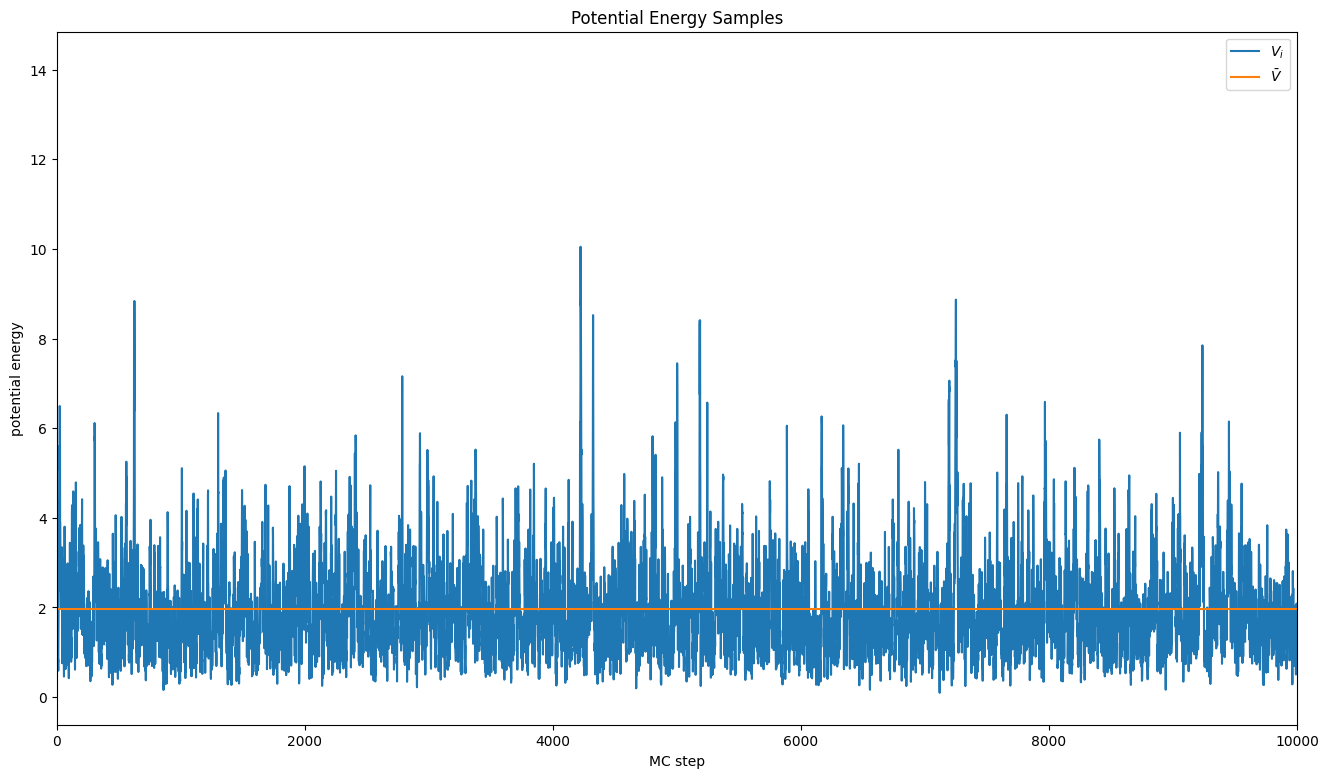

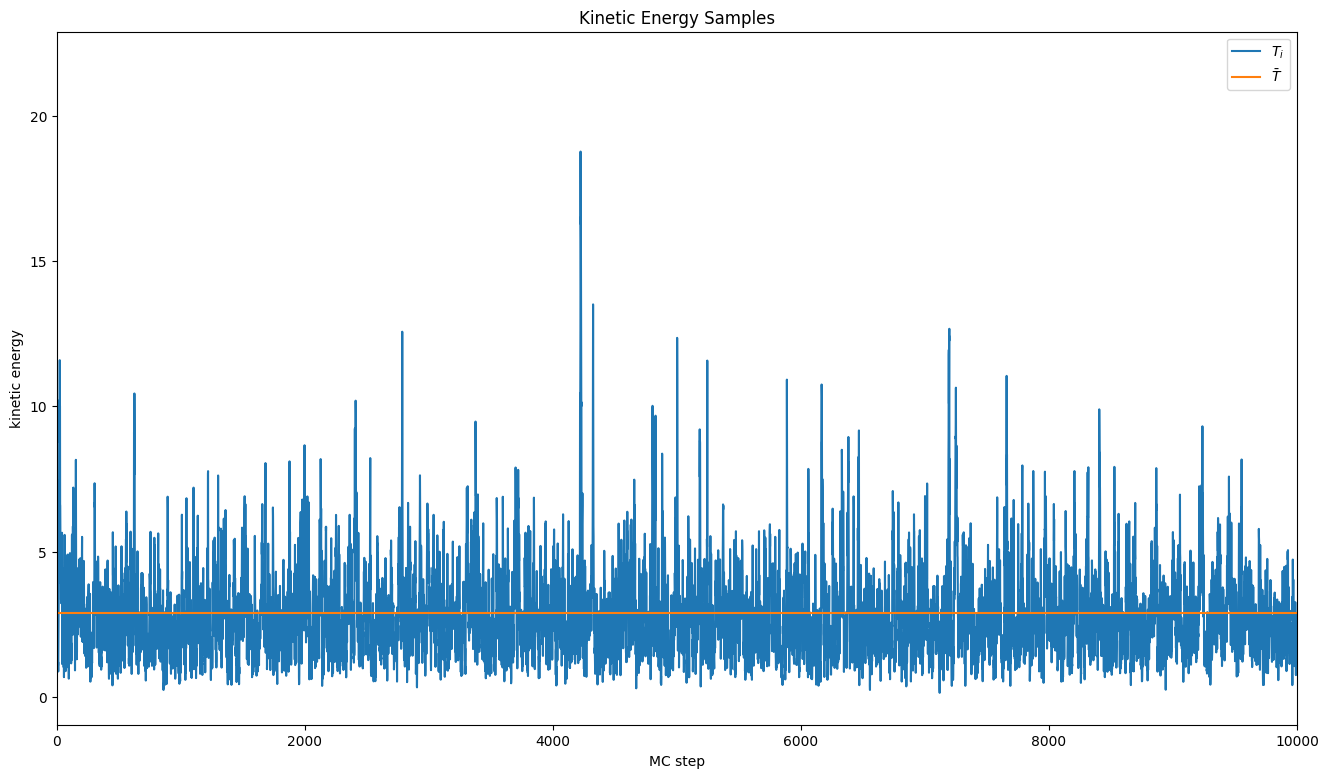

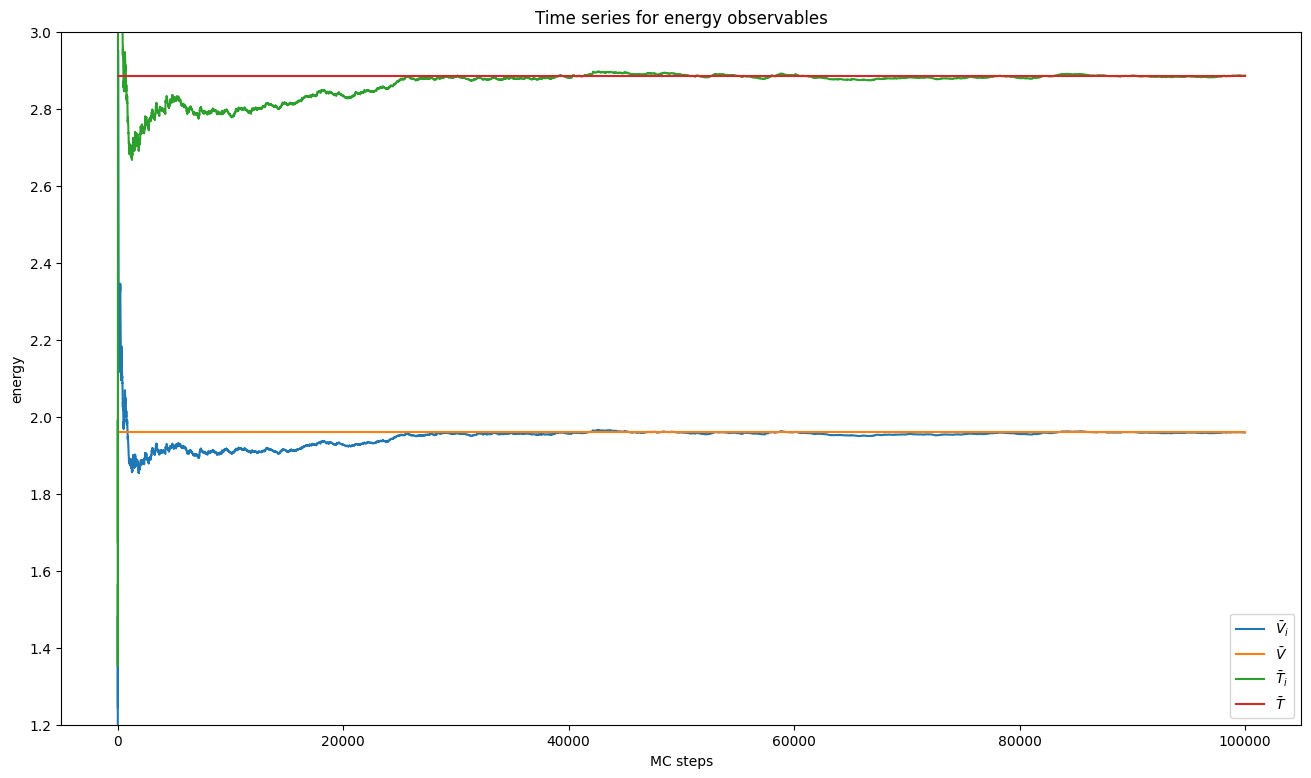

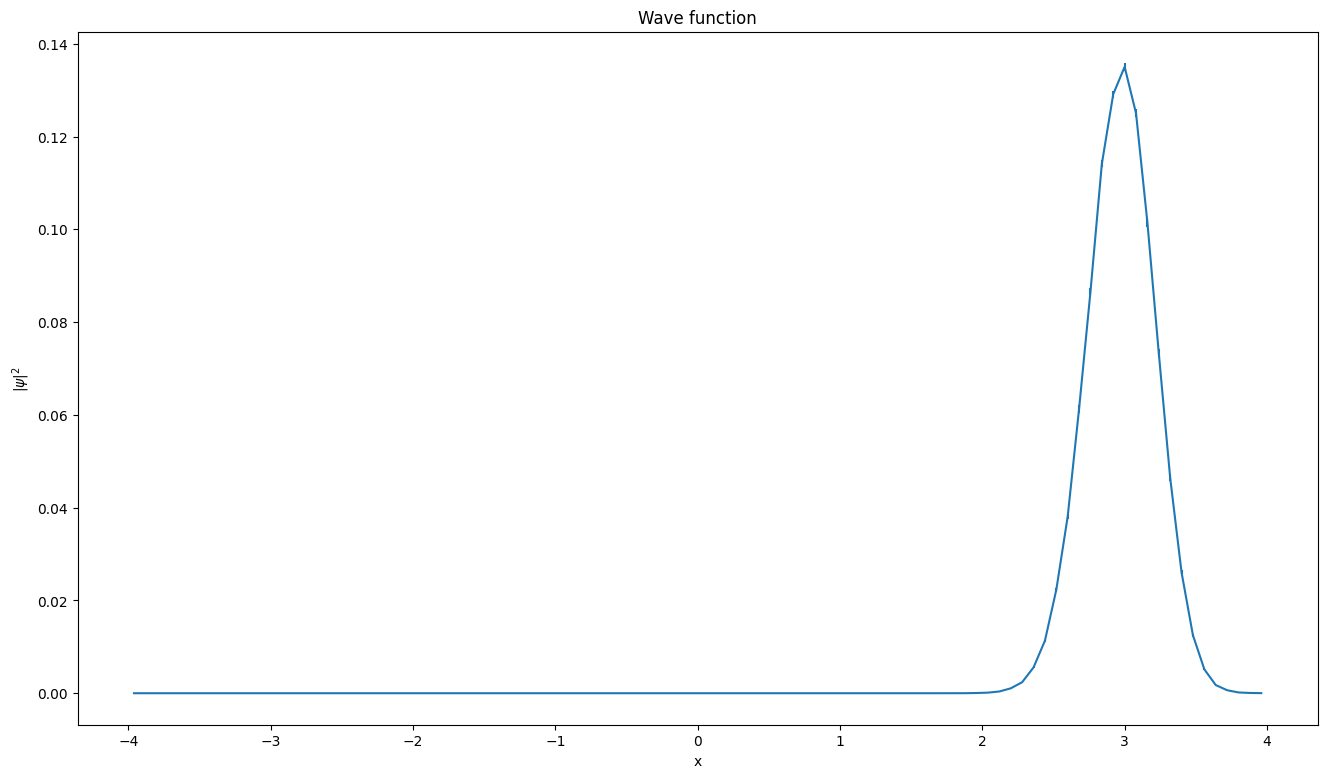

In [27]:
step = 100000
thermal_step = 20000 
eta = [1., 3.]
lims = [[0.2, 0.9], [1.2, 3.]]

for e, lim in zip(eta, lims):
    c = Config(beta, P, lambda x: V_Higgs(x, e), lambda x: dVdx_Higgs(x, e))
    pe, ke, xs = simulate(c, step, thermal_step)
    pe_mean, ke_mean, pe_running, ke_running = autocorrelation_analysis(pe, ke, step)
    plot_energy(pe, ke, pe_mean, ke_mean, pe_running, ke_running, xs, step, lim)
    